In [1]:
from io import BytesIO
import numpy as np
import cv2
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact, interactive, fixed
%matplotlib inline    

In [2]:
def arr2img(arr):
    """Display a 2- or 3-d numpy array as an image."""
    if arr.ndim == 2:
        format, cmap = 'png', mpl.cm.gray
    elif arr.ndim == 3:
        format, cmap = 'jpg', None
    else:
        raise ValueError("Only 2- or 3-d arrays can be displayed as images.")
    # Don't let matplotlib autoscale the color range so we can control overall luminosity
    #vmax = 255 if arr.dtype == 'uint8' else 1.0
    vmax=1.0
    with BytesIO() as buffer:
        mpl.image.imsave(buffer, arr, format=format, cmap=cmap, vmin=0, vmax=vmax)
        out = buffer.getvalue()
    return Image(out)

(399, 600, 3)


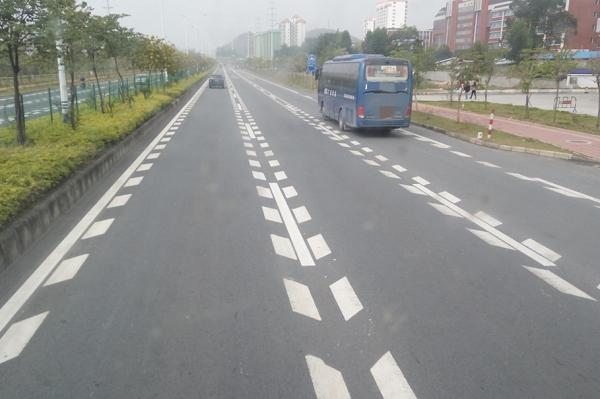

In [3]:
def load_test_images(glob_regex='test_images/*.jpg'):
    images=[]
    for f in glob.glob(glob_regex):
        img=cv2.imread(f)
        #img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append((f,img))
        
    return images

images = load_test_images()
print(images[0][1].shape)
arr2img(cv2.cvtColor(images[0][1], cv2.COLOR_BGR2RGB))

In [4]:
gray1=np.uint8([[[83,72,75]]])
hsv_gray1 = cv2.cvtColor(gray1, cv2.COLOR_BGR2HSV)
gray2=np.uint8([[[74,66,67]]])
hsv_gray2 = cv2.cvtColor(gray2, cv2.COLOR_BGR2HSV)
gray3=np.uint8([[[103,95,96]]])
hsv_gray3 = cv2.cvtColor(gray3, cv2.COLOR_BGR2HSV)
gray4=np.uint8([[[70,72,50]]])
hsv_gray4 = cv2.cvtColor(gray4, cv2.COLOR_BGR2HSV)
print(hsv_gray1,hsv_gray2,hsv_gray3)

[[[128  34  83]]] [[[124  28  74]]] [[[124  20 103]]]


(500, 332, 3)
(200, 100, 3) (100, 100, 3) (100, 100, 3)


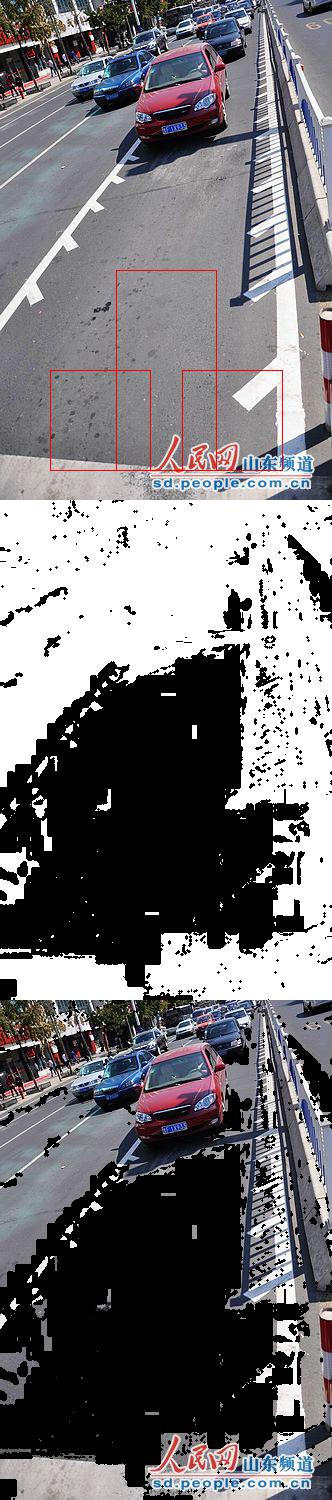

In [5]:
def filter_road_pavement(img):
    img=img.copy()
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     lower_gray = np.array([118, 20, 0])
#     upper_gray = np.array([145, 34, 255])
    
#     mask = cv2.inRange(hsv, lower_gray, upper_gray)
#     result = cv2.bitwise_not(img,img, mask= mask)
    
    print(img.shape)
    width=img.shape[1]
    height=img.shape[0]
    x_center=np.int(width/2)
    roi_width=100
    roi_height=200
    x_left=x_center-np.int(roi_width/2)
    x_right=x_center+np.int(roi_width/2)
    y_top=height-30
    y_bottom=y_top-roi_height
    y_bottom_small=y_top-np.int(roi_height/2)
    x_offset=50
    x_finish=width-x_offset
    
    
    # includes bonnet 
    roi_src=np.int32([(x_left, y_top),
                        (x_left, y_bottom),
                        (x_right, y_bottom),
                        (x_right, y_top)
                       ])
    roi_src_left=np.int32([(x_offset, y_top),
                        (x_offset, y_bottom_small),
                        (x_offset+roi_width, y_bottom_small),
                        (x_offset+roi_width, y_top)
                       ])
    roi_src_right=np.int32([(x_finish, y_top),
                        (x_finish, y_bottom_small),
                        (x_finish-roi_width, y_bottom_small),
                        (x_finish-roi_width, y_top)
                       ])
    
    roi_center=img[y_bottom:y_top, x_left:x_right]
    roi_left=img[y_bottom_small:y_top, x_offset:roi_width+x_offset]
    roi_right=img[y_bottom_small:y_top, x_finish-roi_width:x_finish]
    print(roi_center.shape,roi_left.shape, roi_right.shape)
    roi=np.hstack((roi_center,np.vstack((roi_left,roi_right))))
    roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    
    # calculating object histogram
    roihist = cv2.calcHist([roi_hsv],[0, 1], None, [256, 256], [0, 256, 0, 256] )
#     roihist = cv2.calcHist([roi_hsv],[0], None, [256], [0, 256] )
    
    # normalize histogram and apply backprojection
    cv2.normalize(roihist,roihist,0,255,cv2.NORM_MINMAX)
    dst = cv2.calcBackProject([img_hsv],[0,1],roihist,[0,256,0,256],1)
#     dst = cv2.calcBackProject([img_hsv],[0],roihist,[0,256],1)

    # Now convolute with circular disc
    disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    cv2.filter2D(dst,-1,disc,dst)
    
    # threshold and binary AND
    ret,thresh = cv2.threshold(dst,10,255,cv2.THRESH_BINARY_INV)
#     thresh = cv2.adaptiveThreshold(dst,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,4)
    thresh = cv2.merge((thresh,thresh,thresh))
    res = cv2.bitwise_and(img,thresh)
    img_roi = cv2.polylines(img,[roi_src],True,(0,0,255))
    img_roi = cv2.polylines(img,[roi_src_left],True,(0,0,255))
    img_roi = cv2.polylines(img,[roi_src_right],True,(0,0,255))
    res = np.vstack((img_roi,thresh,res))

    return res

# arr2img(filter_road_gray(images[0][1]))
arr2img(cv2.cvtColor(filter_road_pavement(images[5][1]), cv2.COLOR_BGR2RGB))

In [6]:
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [12]:
#img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.imread('test_images/IMG_2248.JPG')
@interact
def sobel_abs_image(image: fixed(img), 
                    sobel_kernel:(3,21,2)=3, orient:['x','y']='x',
                    thresh_min:(0,100)=20, thresh_max:(100,200)=100):

    grad_binary=abs_sobel_thresh(image, sobel_kernel, orient, (thresh_min, thresh_max))
    return arr2img(grad_binary)

interactive(children=(IntSlider(value=3, description='sobel_kernel', max=21, min=3, step=2), Dropdown(descript…

In [13]:
def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [14]:
#img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.imread('test_images/IMG_2248.jpg')
@interact
def sobel_mag_image(image: fixed(img), 
                sobel_kernel:(3,21,2)=3, mag_min:(0,255)=30, mag_max:(0,255)=100):
  
    mag_binary=mag_threshold(img, sobel_kernel, mag_thresh=(mag_min, mag_max))
    return arr2img(mag_binary)

interactive(children=(IntSlider(value=3, description='sobel_kernel', max=21, min=3, step=2), IntSlider(value=3…

In [15]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [16]:
#img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.imread('test_images/IMG_2248.jpg')
@interact
def sobel_dir_image(image: fixed(img), 
                sobel_kernel:(3,21,2)=3, dir_min:(0.,np.pi/2)=0.7, dir_max:(0,np.pi/2)=1.3):
  
    dir_binary=dir_threshold(img, sobel_kernel, thresh=(dir_min, dir_max))
    return arr2img(dir_binary)

interactive(children=(IntSlider(value=3, description='sobel_kernel', max=21, min=3, step=2), FloatSlider(value…

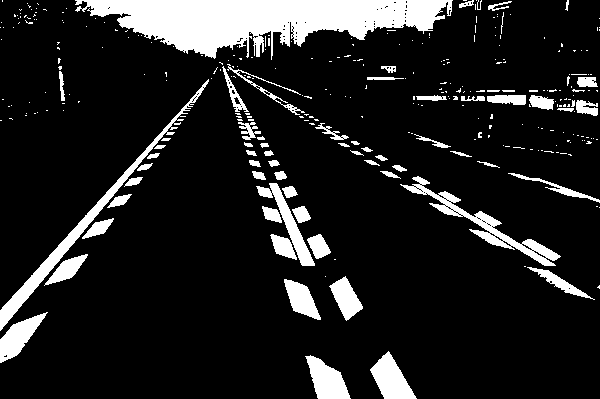

In [18]:
img = cv2.imread('test_images/IMG_2248.jpg')
# img = cv2.imread('test_images/test5.jpg')
thresh = (190, 255)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
arr2img(binary)

In [19]:
R = img[:,:,2]
G = img[:,:,1]
B = img[:,:,0]

def binary_thresh(channel, thresh = (200, 255)):
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary

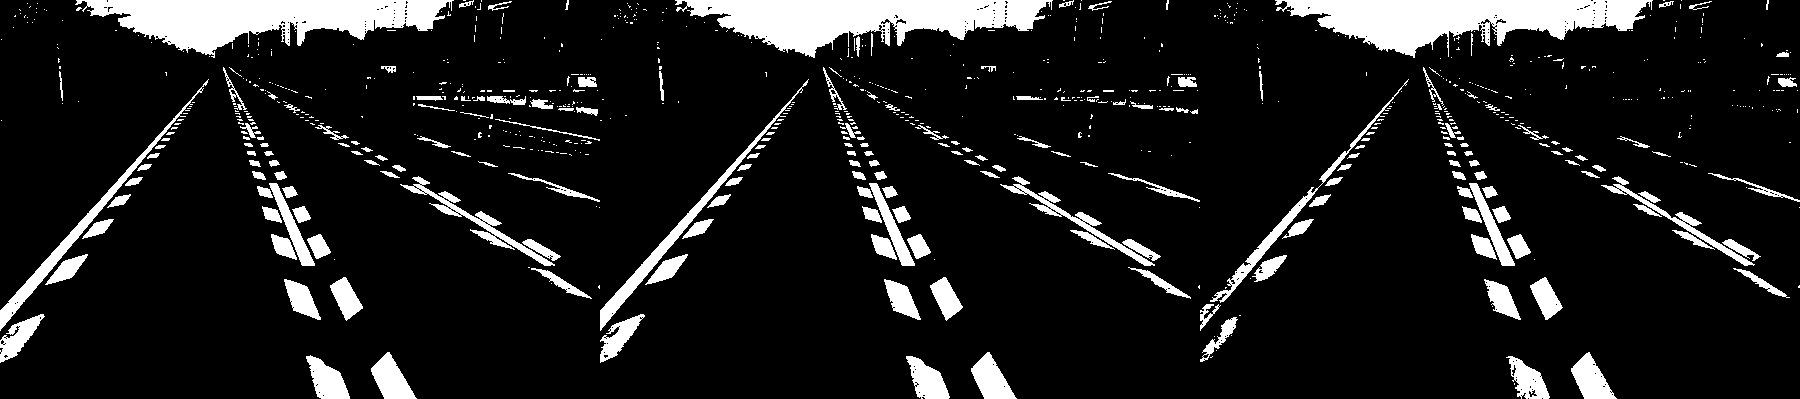

In [20]:
arr2img(np.hstack((binary_thresh(R),binary_thresh(G),binary_thresh(B))))

In [21]:
hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

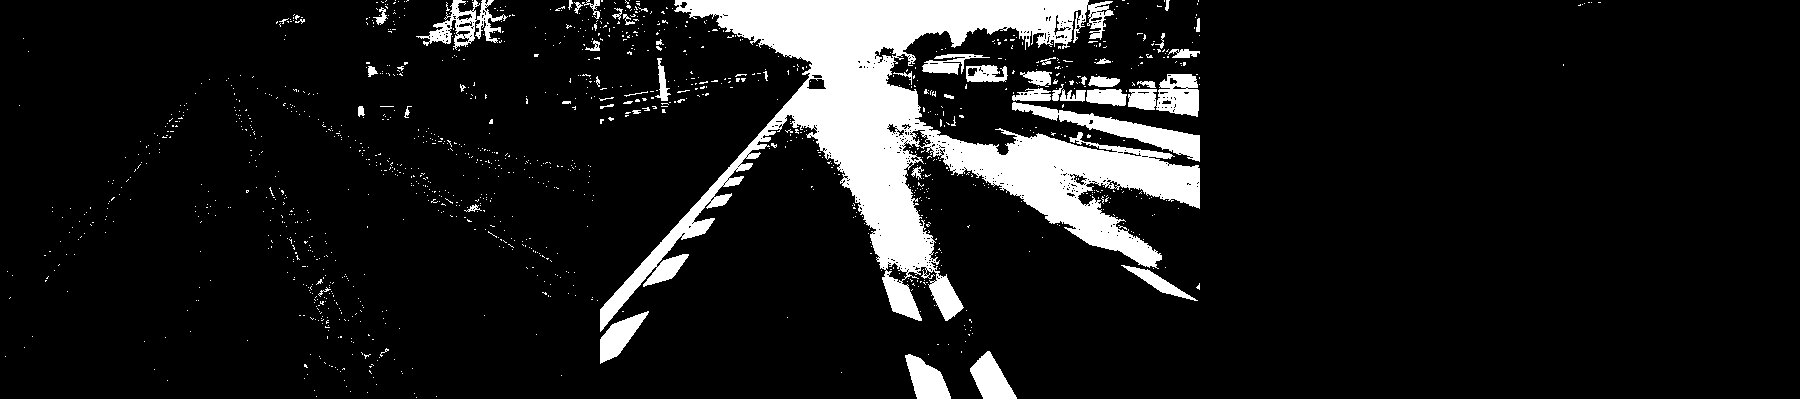

In [22]:
thresh = (150, 255)
arr2img(np.hstack((binary_thresh(H, thresh),binary_thresh(L, thresh),binary_thresh(S, thresh))))

In [23]:
yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
Y = yuv[:,:,0]
U = yuv[:,:,1]
V = yuv[:,:,2]

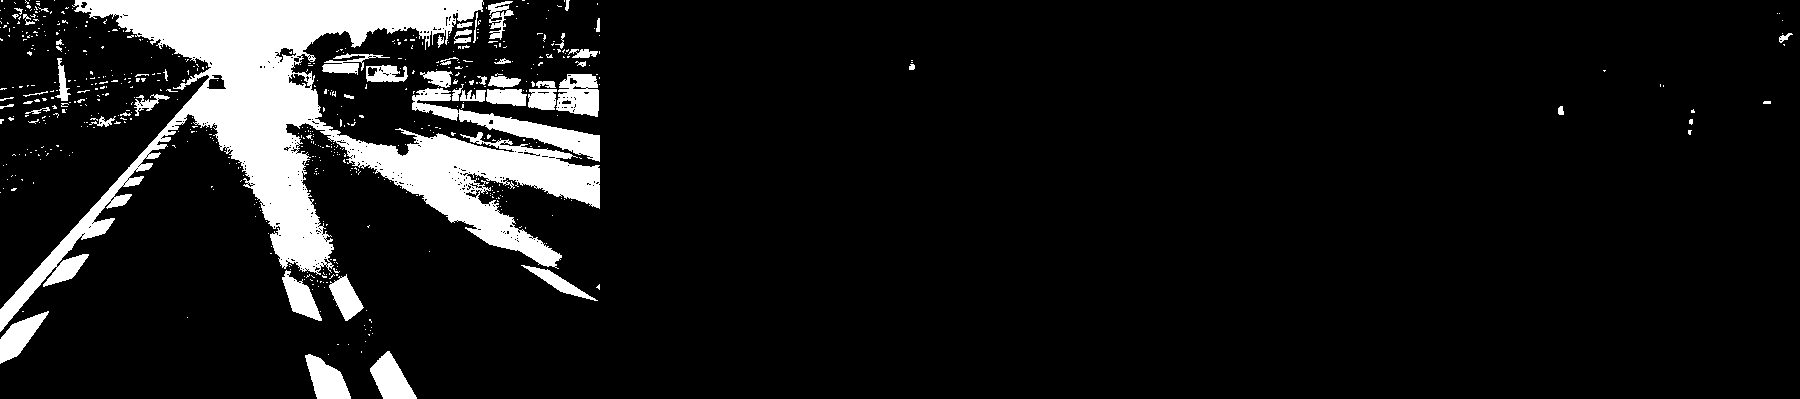

In [24]:
thresh = (150, 255)
arr2img(np.hstack((binary_thresh(Y, thresh),binary_thresh(U, thresh),binary_thresh(V, thresh))))

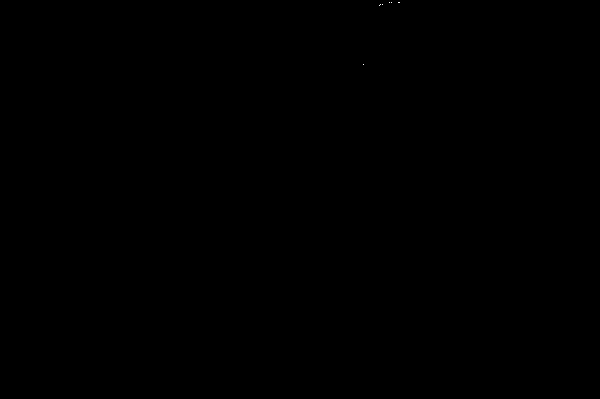

In [25]:
arr2img(binary_thresh(S, thresh=(180,255)))

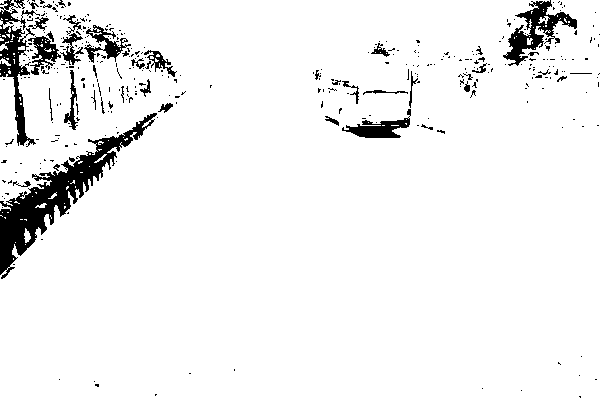

In [26]:
arr2img(binary_thresh(Y, thresh=(100,255)))

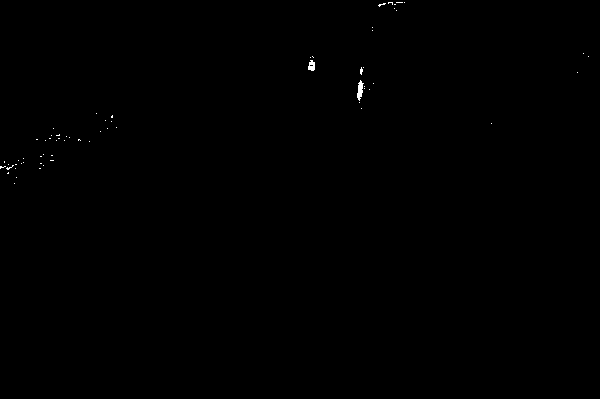

In [27]:
arr2img(binary_thresh(S, thresh=(100,255)) ^ binary_thresh(U, thresh=(145,180)))

In [28]:
def color_binary_pipeline(img, s_thresh=(120, 255), sx_thresh=(30, 100), ksize=3):
    
    # convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary


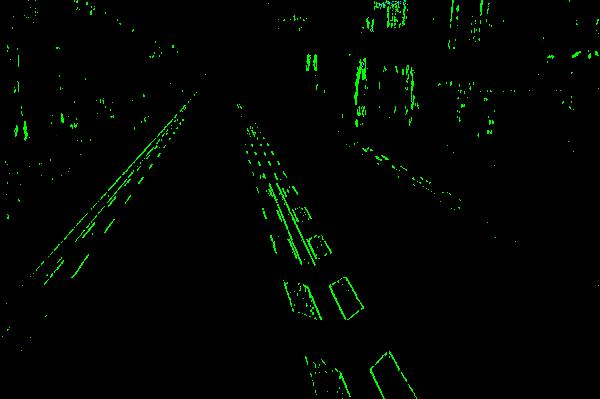

In [29]:
arr2img(color_binary_pipeline(img))

In [30]:
def combined_threshold(img, kernel=3, grad_thresh=(20,100), mag_thresh=(30,100), dir_thresh=(0, np.pi/2),
                       s_thresh=(90,255), r_thresh=(200,255)):

    def binary_thresh(channel, thresh = (200, 255)):
        binary = np.zeros_like(channel)
        binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1

        return binary

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=kernel, thresh=grad_thresh)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=kernel, thresh=grad_thresh)
    mag_binary = mag_threshold(img, sobel_kernel=kernel, mag_thresh=mag_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=kernel, thresh=dir_thresh)
    
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    sbinary = binary_thresh(S, s_thresh)
    
    R = img[:,:,2]
    G = img[:,:,1]
    B = img[:,:,0]
    rbinary = binary_thresh(R, r_thresh)
    
    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (sbinary ==1 ) | (rbinary == 1)] = 1
    combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1)) | (sbinary ==1 ) | (rbinary == 1)] = 1
    #combined[((gradx == 1) | ((mag_binary == 1)) & (dir_binary == 1)) & ( (sbinary ==1 ) | (rbinary == 1))] = 1
    
    
    return combined

In [31]:
images = load_test_images()
@interact
def combined_threshold_image(images=fixed(images), i:(0,len(images)-1)=0, 
                    sobel_kernel:(3,21,2)=3,
                    grad_min:(0,255)=20, grad_max:(0,255)=100,
                    mag_min:(0,255)=30, mag_max:(0,255)=100,
                    dir_min:(0.,np.pi/2)=0.7, dir_max:(0,np.pi/2)=1.3,
                    s_min:(0,255)=90, s_max:(0,255)=255,
                    r_min:(0,255)=200, r_max:(0,255)=255):
  
    file,img=images[i]
    dir_binary=combined_threshold(img, sobel_kernel,
                                  grad_thresh=(grad_min, grad_max),
                                  mag_thresh=(mag_min, mag_max),
                                  dir_thresh=(dir_min, dir_max),
                                  s_thresh=(s_min, s_max),
                                  r_thresh=(r_min, r_max)
                                 )
    return arr2img(dir_binary)

interactive(children=(IntSlider(value=0, description='i', max=5), IntSlider(value=3, description='sobel_kernel…